<a href="https://colab.research.google.com/github/valogonor/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/LS_DS_233_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [2]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


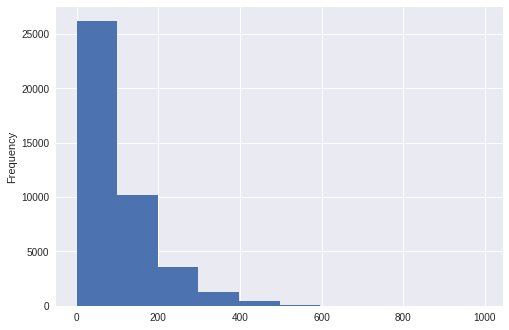

In [4]:
df['pm2.5'].plot.hist();

In [5]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

In [35]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2214
Model:                       QuantReg   Bandwidth:                    0.006093
Method:                 Least Squares   Sparsity:                       0.1007
Date:                Fri, 25 Jan 2019   No. Observations:                41755
Time:                        02:52:19   Df Residuals:                    41743
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.725e-07   1.26e-08     29.551      0.000    3.48e-07    3.97e-07
No         -1.427e-07   2.01e-08     -7.090      0.000   -1.82e-07   -1.03e-07
year           0.0009   2.32e-05     37.367      0.000       0.001       0.001
month         -0.0014   7.73e-05    -18.504      0.000      -0.002      -0.001
day            0.0003   2.81e-05     10.376      0.000       0.000       0.000
hour           0.0011   3.74e-05     28.942      0.000       0.001       0.001
DEWP           0.0037   3.54e-05    104.579      0.000       0.004       0.004
TEMP          -0.0043    4.5e-05    -95.335      0.000      -0.004      -0.004
PRES          -0.0010   4.58e-05    -22.853      0.000      -0.001      -0.001
Iws           -0.0003   5.33e-06    -65.441      0.000      -0.000      -0.000
Is            -0.0005      0.000     -1.505      0.132      -0.001       0.000
Ir            -0.0058      0.000    -33.103      0.000      -0.006      -0.005
==============================================================================

The condition number is large, 3.42e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [7]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [8]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Thu, 24 Jan 2019   No. Observations:                41757
Time:                        22:06:08   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.803      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [9]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

(0.5, 0.1447879336023583)
(0.51, 0.1453046499109799)
(0.52, 0.1457984456251047)
(0.53, 0.14627848333343263)
(0.54, 0.1467640446791706)
(0.55, 0.14733094668790292)
(0.56, 0.14787821797693512)
(0.57, 0.14840185621049273)
(0.58, 0.14892138273908107)
(0.59, 0.14946793972061212)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.6, 0.1500450836285967)
(0.61, 0.15066665485612274)
(0.62, 0.15131550520931825)
(0.63, 0.15201598245712966)
(0.64, 0.152815632180745)
(0.65, 0.15360133883660188)
(0.66, 0.15440046026580068)
(0.67, 0.15521251759239985)
(0.68, 0.15607615678951559)
(0.69, 0.15692695615298136)
(0.7, 0.1577663389046554)
(0.71, 0.15865286212994567)
(0.72, 0.15961363441229715)
(0.73, 0.16062991121153458)
(0.74, 0.1617151201897239)
(0.75, 0.16280951619867146)
(0.76, 0.16394259393342125)
(0.77, 0.16517451474458056)
(0.78, 0.1664423443710097)
(0.79, 0.16770815353095714)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.8, 0.16904227356438506)
(0.81, 0.17037126968955685)
(0.82, 0.17195593122357777)
(0.83, 0.17383892606382623)
(0.84, 0.17599918426382777)
(0.85, 0.17817588507328963)
(0.86, 0.18047434708570964)
(0.87, 0.18274842963575832)
(0.88, 0.1850748927825704)
(0.89, 0.18767194363846373)
(0.9, 0.1899871464061209)
(0.91, 0.19205778885867675)
(0.92, 0.19409258046839573)
(0.93, 0.1960928580149024)
(0.94, 0.1990718585613529)
(0.95, 0.20306510227274233)
(0.96, 0.20828854295993626)
(0.97, 0.21268428179968246)
(0.98, 0.21668870123970496)
(0.99, 0.21742941318156628)


In [36]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
print(quant_reg.summary())  # "summary" is another very R-thing

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:               0.2651
Model:                       QuantReg   Bandwidth:                    0.003297
Method:                 Least Squares   Sparsity:                       0.1137
Date:                Fri, 25 Jan 2019   No. Observations:                41755
Time:                        02:52:40   Df Residuals:                    41743
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.23e-07   1.22e-08     18.253      0.000    1.99e-07    2.47e-07
No         -1.916e-07   1.89e-08    -10.111      0.000   -2.29e-07   -1.54e-07
year           0.0006   2.28e-05     25.163      0.000       0.001       0.001
month         -0.0015   7.05e-05    -21.476      0.0

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [0]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [14]:
import pandas as pd
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [15]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


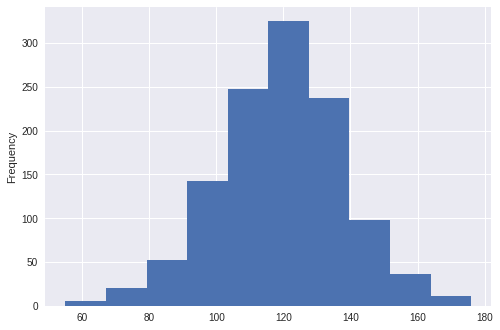

In [16]:
bwt_df['bwt'].plot.hist(); # normal distribution: no need to log

In [17]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
bwt_df = bwt_df._get_numeric_data().dropna()
X = bwt_df.drop('bwt', axis='columns')
y = bwt_df['bwt']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2579534937842991

In [30]:
from scipy import stats
percentile = stats.percentileofscore( bwt_df['bwt'], 90)
percentile

5.664395229982964

In [32]:
# Now let's construct the formula string using all columns
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.0566)
print(quant_reg.summary())

bwt ~ gestation + parity + age + height + weight + smoke
                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1989
Model:                       QuantReg   Bandwidth:                       6.229
Method:                 Least Squares   Sparsity:                        132.4
Date:                Fri, 25 Jan 2019   No. Observations:                 1174
Time:                        02:31:23   Df Residuals:                     1167
                                        Df Model:                            6
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3321     32.589     -2.956      0.003    -160.272     -32.392
gestation      0.4789      0.089      5.381      0.000       0.304       0.654
parity        -3.2501      2.338     -1.390      0.165      -7.837       1

In [34]:
quant_formula = 'bwt ~ gestation + smoke'
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.0566)
print(quant_reg.summary())

bwt ~ gestation + smoke
                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1836
Model:                       QuantReg   Bandwidth:                       6.290
Method:                 Least Squares   Sparsity:                        148.7
Date:                Fri, 25 Jan 2019   No. Observations:                 1174
Time:                        02:50:21   Df Residuals:                     1171
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.4762     28.799     -1.232      0.218     -91.980      21.028
gestation      0.4762      0.103      4.629      0.000       0.274       0.678
smoke         -8.0951      2.071     -3.909      0.000     -12.158      -4.032

The condition number is lar

In [66]:
gestbins = pd.cut(bwt_df.gestation, 10)
pd.crosstab(gestbins, bwt_df.smoke, normalize='columns') #smokers tend to have less gestation

smoke,0,1
gestation,,
"(147.795, 168.5]",0.001399,0.000000
"(168.5, 189.0]",0.001399,0.000000
"(189.0, 209.5]",0.001399,0.000000
"(209.5, 230.0]",0.004196,0.006536
"(230.0, 250.5]",0.036364,0.045752
"(250.5, 271.0]",0.170629,0.224401
"(271.0, 291.5]",0.611189,0.572985
"(291.5, 312.0]",0.151049,0.130719
"(312.0, 332.5]",0.018182,0.019608


In [67]:
quant_formula = 'bwt ~ gestation + smoke + height'
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.0566)
print(quant_reg.summary())

bwt ~ gestation + smoke + height
                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1921
Model:                       QuantReg   Bandwidth:                       5.942
Method:                 Least Squares   Sparsity:                        132.8
Date:                Fri, 25 Jan 2019   No. Observations:                 1174
Time:                        03:54:48   Df Residuals:                     1170
                                        Df Model:                            3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -100.5715     31.164     -3.227      0.001    -161.716     -39.427
gestation      0.5000      0.089      5.595      0.000       0.325       0.675
smoke         -7.9286      1.875     -4.228      0.000     -11.608      -4.249
height         0.92

In [68]:
quant_formula = 'bwt ~ gestation + smoke + height + weight'
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.0566)
print(quant_reg.summary())

bwt ~ gestation + smoke + height + weight
                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1964
Model:                       QuantReg   Bandwidth:                       6.254
Method:                 Least Squares   Sparsity:                        126.9
Date:                Fri, 25 Jan 2019   No. Observations:                 1174
Time:                        03:56:38   Df Residuals:                     1169
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -102.4171     30.676     -3.339      0.001    -162.603     -42.231
gestation      0.4679      0.088      5.346      0.000       0.296       0.640
smoke         -9.6929      1.772     -5.471      0.000     -13.169      -6.217
height    

In [69]:
quant_formula = 'bwt ~ gestation + smoke + height + weight + parity'
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.0566)
print(quant_reg.summary())

bwt ~ gestation + smoke + height + weight + parity
                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1986
Model:                       QuantReg   Bandwidth:                       6.182
Method:                 Least Squares   Sparsity:                        134.1
Date:                Fri, 25 Jan 2019   No. Observations:                 1174
Time:                        03:58:00   Df Residuals:                     1168
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -103.5204     31.709     -3.265      0.001    -165.734     -41.307
gestation      0.4926      0.091      5.394      0.000       0.313       0.672
smoke         -8.8109      1.879     -4.690      0.000     -12.497      -5.125
h

In [72]:
quant_formula = 'bwt ~ gestation'
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.0566)
print(quant_reg.summary())

bwt ~ gestation
                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1626
Model:                       QuantReg   Bandwidth:                       6.316
Method:                 Least Squares   Sparsity:                        132.1
Date:                Fri, 25 Jan 2019   No. Observations:                 1174
Time:                        04:03:19   Df Residuals:                     1172
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -50.0625     25.833     -1.938      0.053    -100.747       0.622
gestation      0.5156      0.093      5.571      0.000       0.334       0.697

The condition number is large, 4.88e+03. This might indicate that there are
strong multicollinearity or other nume

    What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
    What can expectant mothers be told to help mitigate this risk?

The characteristics of a mother that indicate the highest likelihood of an at-risk baby are shorter gestation and smoking.

Expectant mothers can be told not to smoke to mitigate this risk. Smokers also tend to have shorter gestation periods.

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model